In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import os
import scipy.stats
import warnings
from datetime import date, datetime, time, timedelta
warnings.filterwarnings('ignore')
%matplotlib inline
import re
from functools import reduce
from sklearn.metrics import mean_squared_error

plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

In [2]:
''' 
Step 0: Functions
'''

# CSV to DF
def csv_to_df(df, file_name, folder_path):
    file_path = folder_path+ "/" +file_name
    temp_df = pd.read_csv(file_path)
    start_time = temp_df["Start time"].iloc[0]
    start_time = re.sub(':','',start_time)
    start_date = temp_df["Date"].iloc[0]
    start_date = re.sub('-','',start_date)
    new_header = temp_df.iloc[1] 
    temp_df = temp_df[2:] 
    temp_df.columns = new_header 
    temp_df = temp_df[["Time", "HR (bpm)"]].reset_index(drop=True)

    # Convert from relative time to datetime 
    date_var = date(int(start_date[4:]), int(start_date[2:4]), int(start_date[0:2]))
    time_var = time(int(start_time[0:1]),int(start_time[1:3]),int(start_time[3:5]))
    dt_var = datetime.combine(date_var, time_var)
    temp_df["Datetime"] = pd.to_datetime(dt_var)
    temp_df['Time'] = pd.to_timedelta(temp_df['Time'])
    temp_df['Datetime'] = temp_df['Datetime'] + temp_df['Time']
    temp_df.drop(columns=["Time"], inplace=True)

    # Drop first row (no HR data)
    temp_df = temp_df.iloc[1:, :] #.reset_index(drop=True)

    # Rename columns
    temp_df.rename(columns={"HR (bpm)":"HR"}, inplace=True)

    # Combine dfs
    df = pd.concat([df, temp_df], ignore_index=True)
    return df

# Calc Sampling Frequency 
def avg(a):
    numdeltas = len(a) - 1
    sumdeltas = timedelta(seconds=0)

    i = 1
    while i < len(a):
        delta = abs(a[i] - a[i-1])
        try:
            sumdeltas += delta
        except:
            raise
        i += 1
    avg = sumdeltas / numdeltas
    return avg

# Mean Absolute Error
def mae(a, p):
    return np.mean(np.abs(a - p))

# ICC 
def icc(a, p):
    mse = mean_squared_error(a,p)
    avgs = np.mean([a,p])
    DifAvgSq = np.sum(np.square(a - avgs) + np.square(p - avgs))
    icc = 1 - (mse / DifAvgSq)
    return icc  

In [3]:
''' 
Step 1A: Import Watch Data as DF
'''
# Create element tree object
tree = ET.parse("/Users/ellismims/Documents/F23/290T/project/data/watch/export_1128.xml")

# Extract attributes of each health record
root = tree.getroot()
watch_list = [x.attrib for x in root.iter('Record')]
watch_df = pd.DataFrame(watch_list)

# Create element tree object
tree = ET.parse("/Users/ellismims/Documents/F23/290T/project/data/watch/export_1104.xml")

# Extract attributes of each health record
root = tree.getroot()
watch_1018_list = [x.attrib for x in root.iter('Record')]
watch_1018 = pd.DataFrame(watch_1018_list)

print(watch_df.shape)
print(watch_1018.shape)

(870593, 9)
(835473, 9)


In [4]:
''' 
Step 1B: Import Polar Data as DF & Wrangle
'''
# Initialize empty df
polar_df = pd.DataFrame()
polar_path="/Users/ellismims/Documents/F23/290T/project/data/polar"

for fp in os.listdir(polar_path):
    if fp[-3:].lower() == "csv":
        polar_df = csv_to_df(polar_df, fp, polar_path)

polar_df = polar_df.sort_values(by="Datetime").reset_index(drop=True)
polar_df["HR"] = polar_df["HR"].astype(int)
print(polar_df.shape)
polar_df.tail(10)

(23055, 2)


1,HR,Datetime
23045,153,2023-11-22 07:21:53
23046,153,2023-11-22 07:21:54
23047,152,2023-11-22 07:21:55
23048,152,2023-11-22 07:21:56
23049,150,2023-11-22 07:21:57
23050,150,2023-11-22 07:21:58
23051,150,2023-11-22 07:21:59
23052,150,2023-11-22 07:22:00
23053,150,2023-11-22 07:22:01
23054,150,2023-11-22 07:22:02


In [5]:
''' 
Step 2A: Wrangle Watch Data
'''
watch_df[['creationDate', 'startDate', 'endDate']] = watch_df[['creationDate', 'startDate', 'endDate']].apply(pd.to_datetime)

watch_df['type'] = watch_df['type'].str.replace('HKQuantityTypeIdentifier', '')
watch_df['sourceName'] = watch_df['sourceName'].str.replace("Ellis’s Apple\xa0Watch", "AppleWatch")

# Filter for heart rate data collected by Apple Watch
watch_df = watch_df[(watch_df["sourceName"] == "AppleWatch") & 
                         (watch_df["type"] == "HeartRate")]

# Drop unnecessary columns
watch_df = watch_df[["startDate", "value"]].reset_index(drop=True)
print(watch_df.shape)

# Rename columns
watch_df.rename(columns={"startDate":"Datetime", "value":"HR"}, inplace=True)

# Convert to datetime and drop timezone info
watch_df["Datetime"] = pd.to_datetime(watch_df["Datetime"], format='%Y-%m-%d %H:%M:%S')
watch_df["Datetime"] = watch_df["Datetime"].apply(lambda x: x.replace(tzinfo=None))

watch_df = watch_df.sort_values(by="Datetime").reset_index(drop=True)
watch_df.head()

(152271, 2)


,Datetime,HR
0,2023-03-05 16:23:11,68.7989
1,2023-03-05 16:23:16,67
2,2023-03-05 16:28:00,66
3,2023-03-05 16:30:19,43
4,2023-03-05 16:47:06,66


In [6]:
''' 
Step 2B: Wrangle Watch 10-18 Data
'''
watch_1018[['creationDate', 'startDate', 'endDate']] = watch_1018[['creationDate', 'startDate', 'endDate']].apply(pd.to_datetime)

watch_1018['type'] = watch_1018['type'].str.replace('HKQuantityTypeIdentifier', '')
watch_1018['sourceName'] = watch_1018['sourceName'].str.replace("Ellis’s Apple\xa0Watch", "AppleWatch")

# Filter for heart rate data collected by Apple Watch
watch_1018 = watch_1018[(watch_1018["sourceName"] == "AppleWatch") & 
                         (watch_1018["type"] == "HeartRate")]

# Drop unnecessary columns
watch_1018 = watch_1018[["startDate", "value"]].reset_index(drop=True)
print(watch_1018.shape)

# Rename columns
watch_1018.rename(columns={"startDate":"Datetime", "value":"HR"}, inplace=True)

# Convert to datetime and drop timezone info
watch_1018["Datetime"] = pd.to_datetime(watch_1018["Datetime"], format='%Y-%m-%d %H:%M:%S')
watch_1018["Datetime"] = watch_1018["Datetime"].apply(lambda x: x.replace(tzinfo=None))

watch_1018 = watch_1018.sort_values(by="Datetime").reset_index(drop=True)
watch_1018.head()

(139948, 2)


,Datetime,HR
0,2023-03-05 17:23:11,68.7989
1,2023-03-05 17:23:16,67
2,2023-03-05 17:28:00,66
3,2023-03-05 17:30:19,43
4,2023-03-05 17:47:06,66


In [7]:
''' 
Step 2C: Reconcile Polar and Watch data
'''

# Get dates of each Polar session
date_list = polar_df["Datetime"].dt.date.unique().tolist()

match_indexes = []

min_polar = polar_df[polar_df["Datetime"].dt.date == date_list[0]]["Datetime"].min()  
max_polar = polar_df[polar_df["Datetime"].dt.date == date_list[0]]["Datetime"].max()
match_index = watch_1018["Datetime"].between(min_polar, max_polar)
filter_watch_1018 = watch_1018[reduce(lambda a,b: a|b, [match_index])].reset_index(drop=True)
print(min_polar)
print(max_polar)

for dte in date_list[1:]:  
    min_polar = polar_df[polar_df["Datetime"].dt.date == dte]["Datetime"].min()  
    max_polar = polar_df[polar_df["Datetime"].dt.date == dte]["Datetime"].max()

    match_index = watch_df["Datetime"].between(min_polar, max_polar)
    match_indexes.append(match_index)
    print(min_polar)
    print(max_polar)

filter_watch_df = watch_df[reduce(lambda a,b: a|b, match_indexes)].reset_index(drop=True)

2023-10-18 05:41:17
2023-10-18 07:16:34
2023-11-17 05:48:27
2023-11-17 07:14:28
2023-11-20 05:38:28
2023-11-20 07:17:11
2023-11-22 05:37:52
2023-11-22 07:22:02


In [8]:
# Concat 1018 with remaining sessions
full_watch_df = pd.concat([filter_watch_1018,filter_watch_df]) 
full_watch_df["HR"] = full_watch_df["HR"].astype(int)
full_watch_df.shape

# Create dateframes for each date 
polar_1018 = polar_df[polar_df["Datetime"].dt.date == pd.to_datetime("2023-10-18").date()]
polar_1117 = polar_df[polar_df["Datetime"].dt.date == pd.to_datetime("2023-11-17").date()]
polar_1120 = polar_df[polar_df["Datetime"].dt.date == pd.to_datetime("2023-11-20").date()]
polar_1122 = polar_df[polar_df["Datetime"].dt.date == pd.to_datetime("2023-11-22").date()]
watch_1117 = full_watch_df[full_watch_df["Datetime"].dt.date == pd.to_datetime("2023-11-17").date()]
watch_1120 = full_watch_df[full_watch_df["Datetime"].dt.date == pd.to_datetime("2023-11-20").date()]
watch_1122 = full_watch_df[full_watch_df["Datetime"].dt.date == pd.to_datetime("2023-11-22").date()]

In [9]:
''' 
Step 2D: Calculate Sampling Frequencies 
'''

sampling_freqs = []
for df in [filter_watch_1018, watch_1117, watch_1120, watch_1122]:
    # Diff to get timedeltas between rows  
    time_deltas = df["Datetime"].diff()
    
    # Exclude NaN at index 0 by slicing
    time_deltas = time_deltas[1:]
    
    # Average timedeltas gives freq  
    freq = time_deltas.mean()
    sampling_freqs.append(freq)
    
# Average the frequencies   
watch_freq = sum(f.total_seconds() for f in sampling_freqs) / len(sampling_freqs)
polar_freq = avg(polar_1018["Datetime"]).total_seconds()
print(f"Polar sampling frequency: {polar_freq}")
print(f"Apple Watch sampling frequency: {watch_freq:.4}")

print(f"\nFor 10-18 session, Apple Watch collected {filter_watch_1018.shape[0]} data points and Polar collected {polar_1018.shape[0]} points.")

Polar sampling frequency: 1.0
Apple Watch sampling frequency: 6.26

For 10-18 session, Apple Watch collected 981 data points and Polar collected 5718 points.


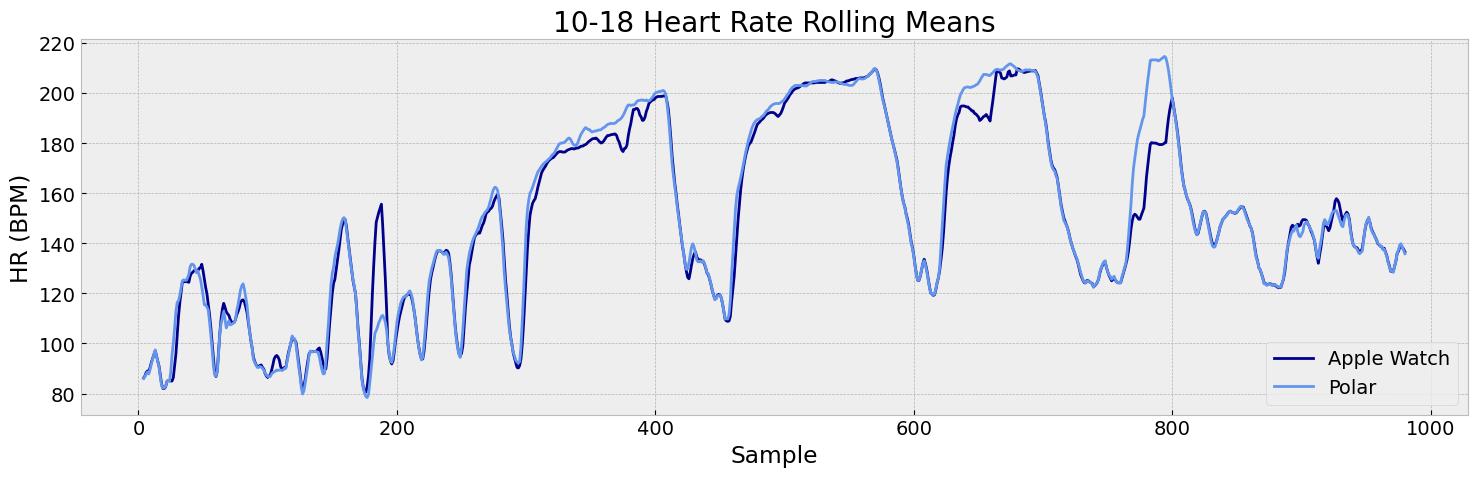

In [12]:
'''
Step 3: Plot & Evaluate (10-18)
'''

# Keep only values with shared timestamps 
polar_1018_sync = polar_1018[polar_1018["Datetime"].isin(watch_1018["Datetime"])].reset_index()["HR"].astype(int)
watch_1018_sync = watch_1018[watch_1018["Datetime"].isin(polar_1018["Datetime"])].reset_index()["HR"].astype(int)

fig, ax = plt.subplots()

ax.set_title('10-18 Heart Rate Rolling Means')
ax.plot(watch_1018_sync.rolling(5).mean(), color='darkblue', label='Apple Watch') 
ax.plot(polar_1018_sync.rolling(5).mean(), color='cornflowerblue', label='Polar')

ax.set_xlabel('Sample')
ax.set_ylabel('HR (BPM)')
ax.legend(loc=4)

ax.grid(axis='y', linestyle='--')
fig.tight_layout() 

fig.savefig('hr_rolling_means.png', transparent=True)
plt.savefig('/Users/ellismims/Documents/F23/290T/project/fig/10-18_sync.png', transparent=True)
plt.show();

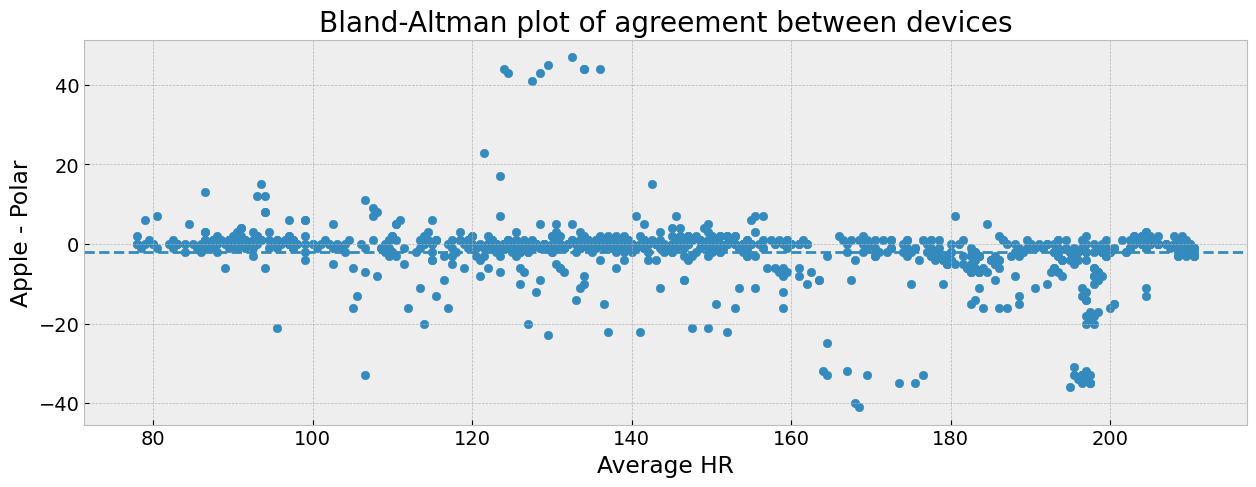

----------10-18----------
MAE: 3.964
Pearson Correlation: 0.977
ICC: 1.0


In [23]:
mae_dict={}
pearsons_dict={}
icc_dict={}

# Bland-Altman Plot
mean_hr = np.mean([watch_1018_sync, polar_1018_sync], axis=0)
diff_hr = watch_1018_sync - polar_1018_sync

plt.scatter(mean_hr, diff_hr)
plt.axhline(np.mean(diff_hr), linestyle='--') 
plt.title("Bland-Altman plot of agreement between devices")
plt.ylabel('Apple - Polar')
plt.xlabel('Average HR')
plt.show()

print(f"{'-'*10}10-18{'-'*10}")
mae_val = mae(watch_1018_sync, polar_1018_sync)
print(f'MAE: {mae_val:.4}')

# Pearson Correlation 
pearsons=scipy.stats.pearsonr(watch_1018_sync, polar_1018_sync)
print(f'Pearson Correlation: {pearsons[0]:.4}')

# ICC 
icc_val = icc(watch_1018_sync, polar_1018_sync)
print(f'ICC: {icc_val:.4}')

mae_dict["10-18"]=mae_val
pearsons_dict["10-18"]=pearsons
icc_dict["10-18"]=icc_val

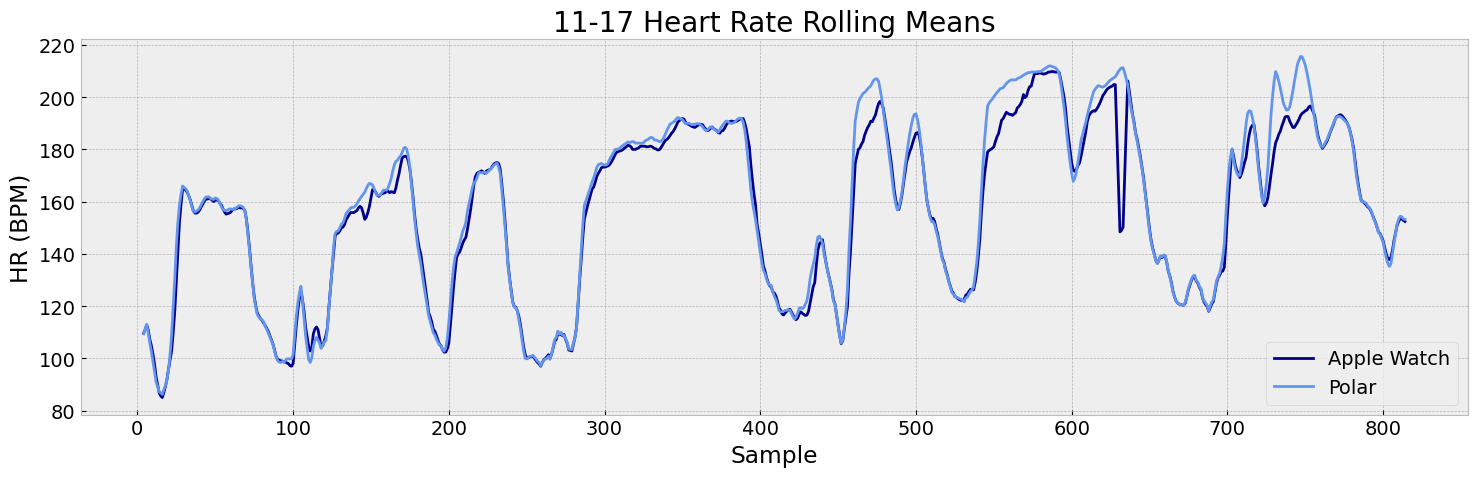

In [24]:
'''
Step 3: Plot & Evaluate (11-17)
'''
# Keep only values with shared timestamps 
polar_1117_sync = polar_1117[polar_1117["Datetime"].isin(watch_1117["Datetime"])].reset_index()["HR"].astype(int)
watch_1117_sync = watch_1117[watch_1117["Datetime"].isin(polar_1117["Datetime"])].reset_index()["HR"].astype(int)

fig, ax = plt.subplots()

ax.set_title('11-17 Heart Rate Rolling Means')
ax.plot(watch_1117_sync.rolling(5).mean(), color='darkblue', label='Apple Watch') 
ax.plot(polar_1117_sync.rolling(5).mean(), color='cornflowerblue', label='Polar')

ax.set_xlabel('Sample')
ax.set_ylabel('HR (BPM)')
ax.legend(loc=4)

ax.grid(axis='y', linestyle='--')
fig.tight_layout() 

fig.savefig('hr_rolling_means.png', transparent=True)
plt.savefig('/Users/ellismims/Documents/F23/290T/project/fig/11-17_sync.png', transparent=True)
plt.show();

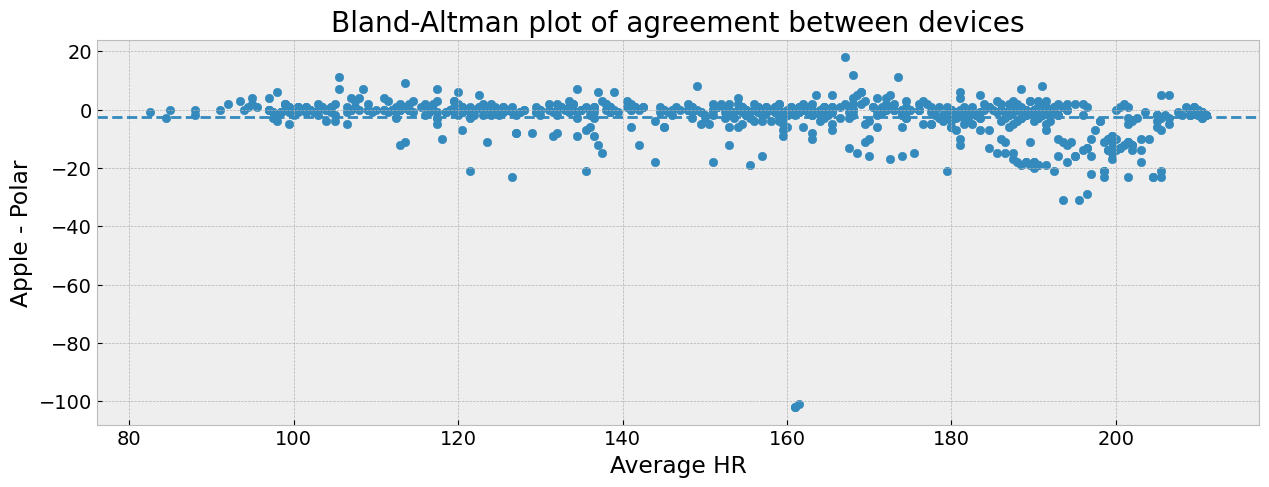

----------11-17----------
MAE: 3.866
Pearson Correlation: 0.9703
ICC: 1.0


In [25]:
# Bland-Altman Plot
mean_hr = np.mean([watch_1117_sync, polar_1117_sync], axis=0)
diff_hr = watch_1117_sync - polar_1117_sync

plt.scatter(mean_hr, diff_hr)
plt.axhline(np.mean(diff_hr), linestyle='--') 
plt.title("Bland-Altman plot of agreement between devices")
plt.ylabel('Apple - Polar')
plt.xlabel('Average HR')
plt.show()

print(f"{'-'*10}11-17{'-'*10}")

# Mean Absolute Error
mae_val=mae(watch_1117_sync, polar_1117_sync)
print(f'MAE: {mae_val:.4}')

# Pearson Correlation 
pearsons=scipy.stats.pearsonr(watch_1117_sync, polar_1117_sync)
print(f'Pearson Correlation: {pearsons[0]:.4}')

# ICC 
icc_val=icc(watch_1117_sync, polar_1117_sync)
print(f'ICC: {icc_val:.4}')

mae_dict["11-17"]=mae_val
pearsons_dict["11-17"]=pearsons
icc_dict["11-17"]=icc_val

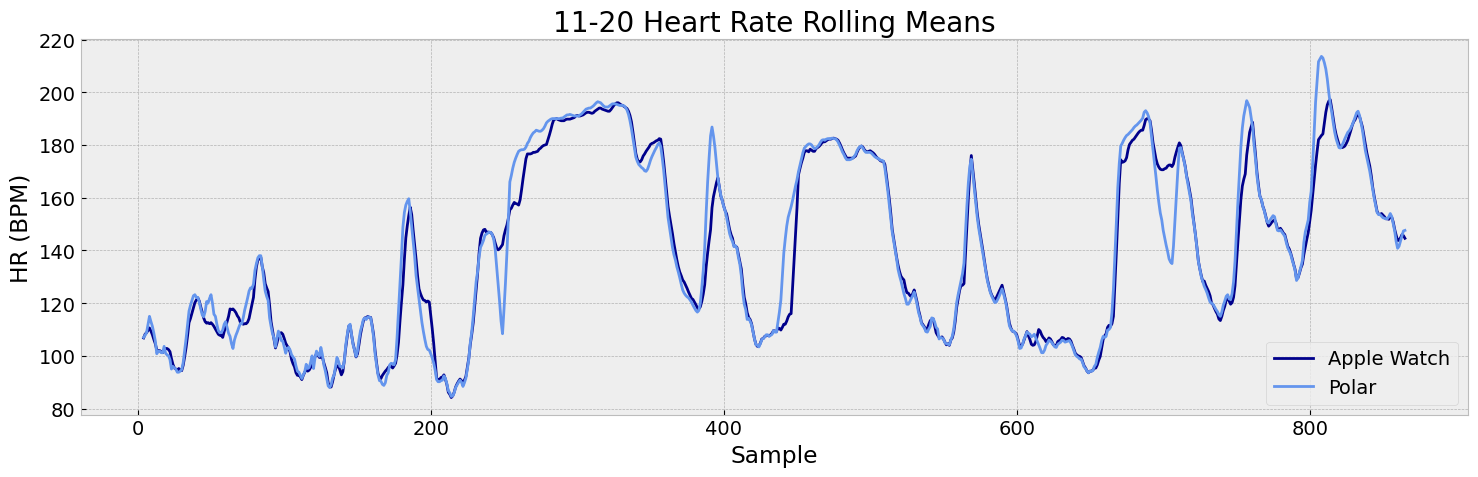

In [26]:
'''
Step 3: Plot & Evaluate (11-20)
'''
polar_1120_sync = polar_1120[polar_1120["Datetime"].isin(watch_1120["Datetime"])].reset_index()["HR"].astype(int)
watch_1120_sync = watch_1120[watch_1120["Datetime"].isin(polar_1120["Datetime"])].reset_index()["HR"].astype(int)

fig, ax = plt.subplots()

ax.set_title('11-20 Heart Rate Rolling Means')
ax.plot(watch_1120_sync.rolling(5).mean(), color='darkblue', label='Apple Watch') 
ax.plot(polar_1120_sync.rolling(5).mean(), color='cornflowerblue', label='Polar')

ax.set_xlabel('Sample')
ax.set_ylabel('HR (BPM)')
ax.legend(loc=4)

ax.grid(axis='y', linestyle='--')
fig.tight_layout() 

fig.savefig('hr_rolling_means.png', transparent=True)
plt.savefig('/Users/ellismims/Documents/F23/290T/project/fig/11-20_sync.png', transparent=True)
plt.show();

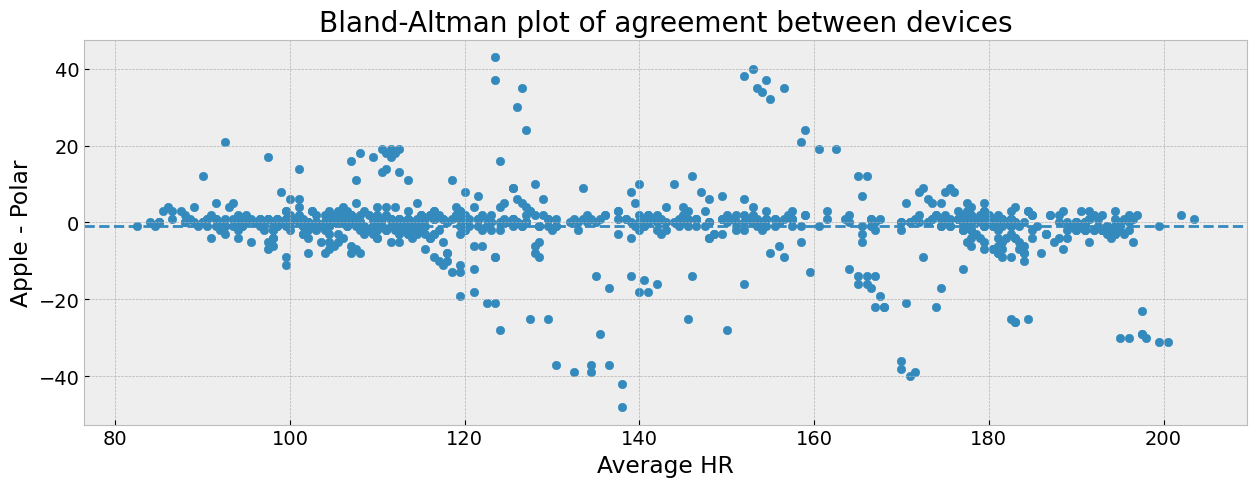

----------11-20----------
MAE: 4.508
Pearson Correlation: 0.9666
ICC: 1.0


In [27]:
# Bland-Altman Plot
mean_hr = np.mean([watch_1120_sync, polar_1120_sync], axis=0)
diff_hr = watch_1120_sync - polar_1120_sync

plt.scatter(mean_hr, diff_hr)
plt.axhline(np.mean(diff_hr), linestyle='--') 
plt.title("Bland-Altman plot of agreement between devices")
plt.ylabel('Apple - Polar')
plt.xlabel('Average HR')
plt.show()

print(f"{'-'*10}11-20{'-'*10}")

# Mean Absolute Error
mae_val = mae(watch_1120_sync, polar_1120_sync)
print(f'MAE: {mae_val:.4}')

# Pearson Correlation 
pearsons=scipy.stats.pearsonr(watch_1120_sync, polar_1120_sync)
print(f'Pearson Correlation: {pearsons[0]:.4}')

# ICC 
icc_val=icc(watch_1120_sync, polar_1120_sync)
print(f'ICC: {icc_val:.4}')

mae_dict["11-20"]=mae_val
pearsons_dict["11-20"]=pearsons
icc_dict["11-20"]=icc_val

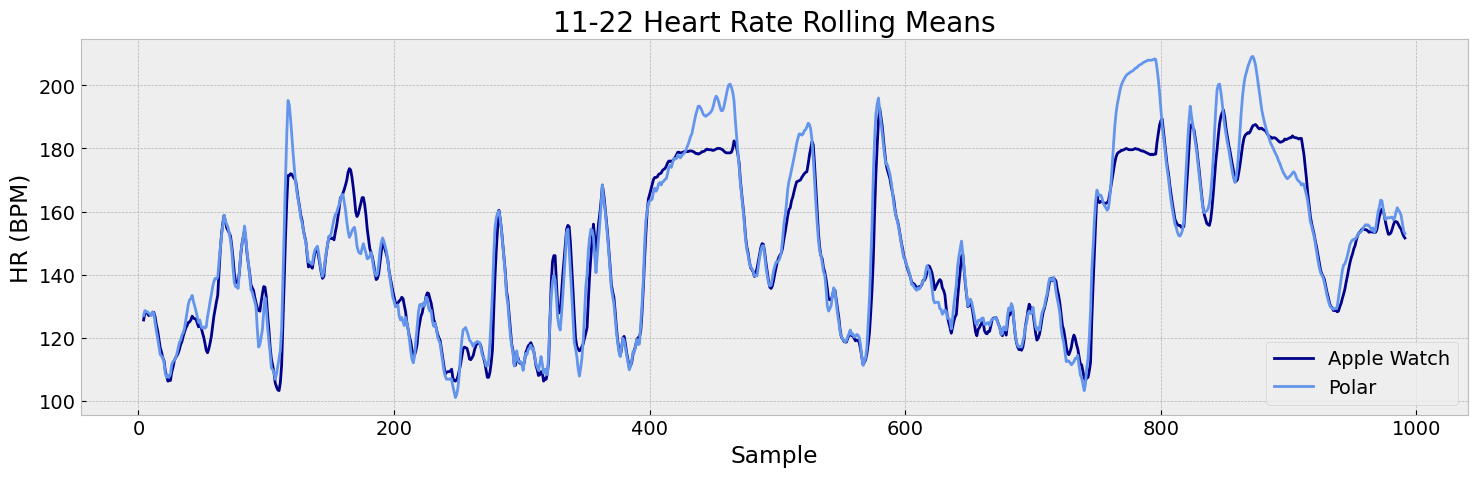

In [29]:
''' 
Step 3: Plot & Evaluate (11-22)
'''
polar_1122_sync = polar_1122[polar_1122["Datetime"].isin(watch_1122["Datetime"])].reset_index()["HR"].astype(int)
watch_1122_sync = watch_1122[watch_1122["Datetime"].isin(polar_1122["Datetime"])].reset_index()["HR"].astype(int)

fig, ax = plt.subplots()

ax.set_title('11-22 Heart Rate Rolling Means')
ax.plot(watch_1122_sync.rolling(5).mean(), color='darkblue', label='Apple Watch') 
ax.plot(polar_1122_sync.rolling(5).mean(), color='cornflowerblue', label='Polar')

ax.set_xlabel('Sample')
ax.set_ylabel('HR (BPM)')
ax.legend(loc=4)

ax.grid(axis='y', linestyle='--')
fig.tight_layout() 

fig.savefig('hr_rolling_means.png', transparent=True)
plt.savefig('/Users/ellismims/Documents/F23/290T/project/fig/11-22_sync.png', transparent=True)
plt.show()

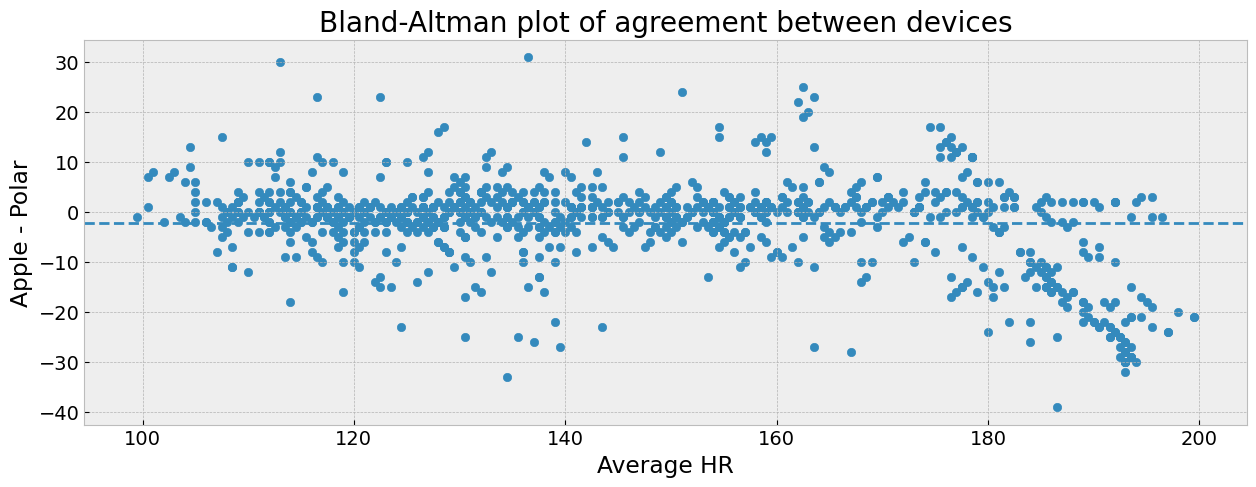

----------11-22----------
MAE: 5.744
Pearson Correlation: 0.9499
ICC: 0.9999


In [30]:
# Bland-Altman Plot
mean_hr = np.mean([watch_1122_sync, polar_1122_sync], axis=0)
diff_hr = watch_1122_sync - polar_1122_sync

plt.scatter(mean_hr, diff_hr)
plt.axhline(np.mean(diff_hr), linestyle='--') 
plt.title("Bland-Altman plot of agreement between devices")
plt.ylabel('Apple - Polar')
plt.xlabel('Average HR')
plt.show()

print(f"{'-'*10}11-22{'-'*10}")

# Mean Absolute Error
mae_val = mae(watch_1122_sync, polar_1122_sync)
print(f'MAE: {mae_val:.4}')

# Pearson Correlation 
pearsons=scipy.stats.pearsonr(watch_1122_sync, polar_1122_sync)
print(f'Pearson Correlation: {pearsons[0]:.4}')

# ICC 
icc_val=icc(watch_1122_sync, polar_1122_sync)
print(f'ICC: {icc_val:.4}')

mae_dict["11-22"]=mae_val
pearsons_dict["11-22"]=pearsons
icc_dict["11-22"]=icc_val

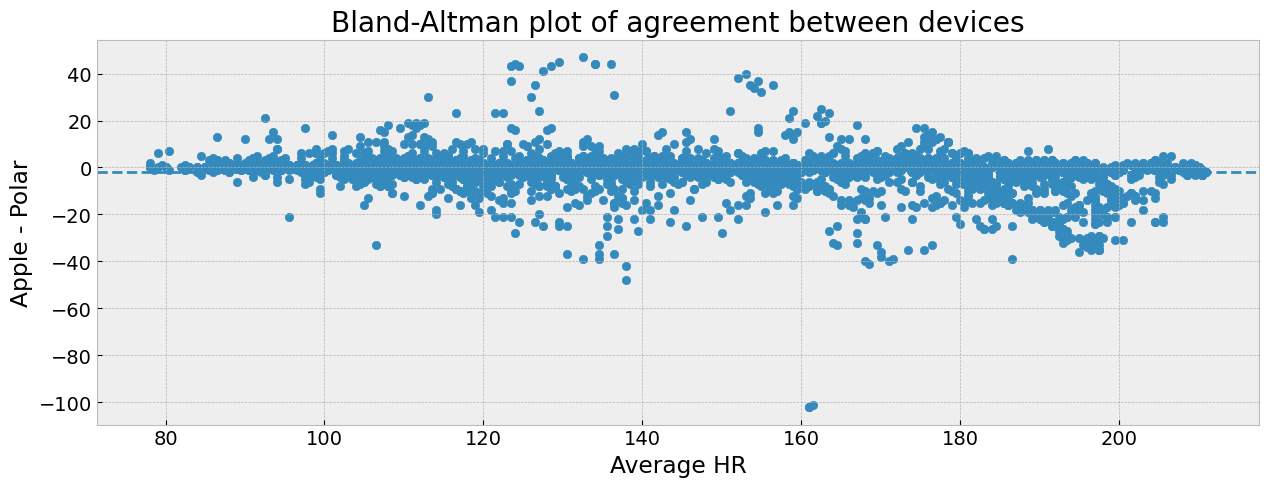

MAE: 4.554 bpm
Pearson Correlation: 0.9689
ICC: 1.0


In [31]:
'''
Step 3: Plot & Evaluate (TOTAL)
'''
polar_sync = polar_df[polar_df["Datetime"].isin(full_watch_df["Datetime"])].reset_index()["HR"].astype(int)
watch_sync = full_watch_df[full_watch_df["Datetime"].isin(polar_df["Datetime"])].reset_index()["HR"].astype(int)

# Bland-Altman Plot
mean_hr = np.mean([watch_sync, polar_sync], axis=0)
diff_hr = watch_sync - polar_sync

plt.scatter(mean_hr, diff_hr)
plt.axhline(np.mean(diff_hr), linestyle='--') 
plt.title("Bland-Altman plot of agreement between devices")
plt.ylabel('Apple - Polar')
plt.xlabel('Average HR')
plt.show()

# Mean Absolute Error
mae_val=mae(watch_sync, polar_sync)
print(f'MAE: {mae_val:.4} bpm')

# Pearson Correlation 
pearsons=scipy.stats.pearsonr(watch_sync, polar_sync)
print(f'Pearson Correlation: {pearsons[0]:.4}')

# ICC 
icc_val=icc(watch_sync, polar_sync)
print(f'ICC: {icc_val:.4}')

mae_dict["total"]=mae_val
pearsons_dict["total"]=pearsons
icc_dict["total"]=icc_val

In [21]:
'''
Step 4: Filter by HR zones 
'''
# Find max HR
max_hr = max(polar_df["HR"].astype(int).max(), full_watch_df["HR"].astype(int).max())

polar_zones = polar_df[polar_df["Datetime"].isin(full_watch_df["Datetime"])].reset_index()
watch_zones = full_watch_df[full_watch_df["Datetime"].isin(polar_df["Datetime"])].reset_index()
polar_zones["HR"] = polar_zones["HR"].astype(int)
watch_zones["HR"] = watch_zones["HR"].astype(int)

#Define zone ranges
zone_ranges = [(0,106), (106,119), (119,142), (142, 178), (178, max_hr+1)]
zone_names = ['Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5']

# Add empty zone columns 
polar_zones['Zones'] = ""
watch_zones['Zones'] = ""

# Filter by each zone  
for i, zone in enumerate(zone_names):
    # Filter Polar for zones  
    polar_filter = (polar_zones['HR'] >= zone_ranges[i][0]) & (polar_zones['HR'] < zone_ranges[i][1])  
    # Assign zone name for rows meeting filter         
    polar_zones.loc[polar_filter, 'Zones'] = zone

    # Filter Watch for zones  
    watch_filter = (watch_zones['HR'] >= zone_ranges[i][0]) & (watch_zones['HR'] < zone_ranges[i][1])  
    # Assign zone name for rows meeting filter         
    watch_zones.loc[watch_filter, 'Zones'] = zone


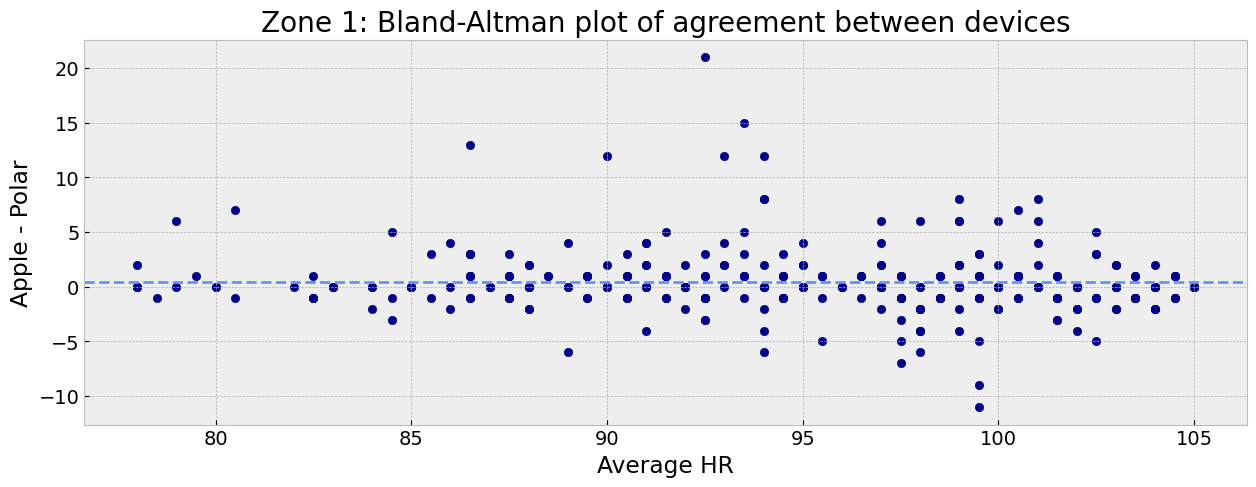

Zone 1
MAE: 1.644 bpm
Pearson Correlation: 0.9069
ICC: 0.9997


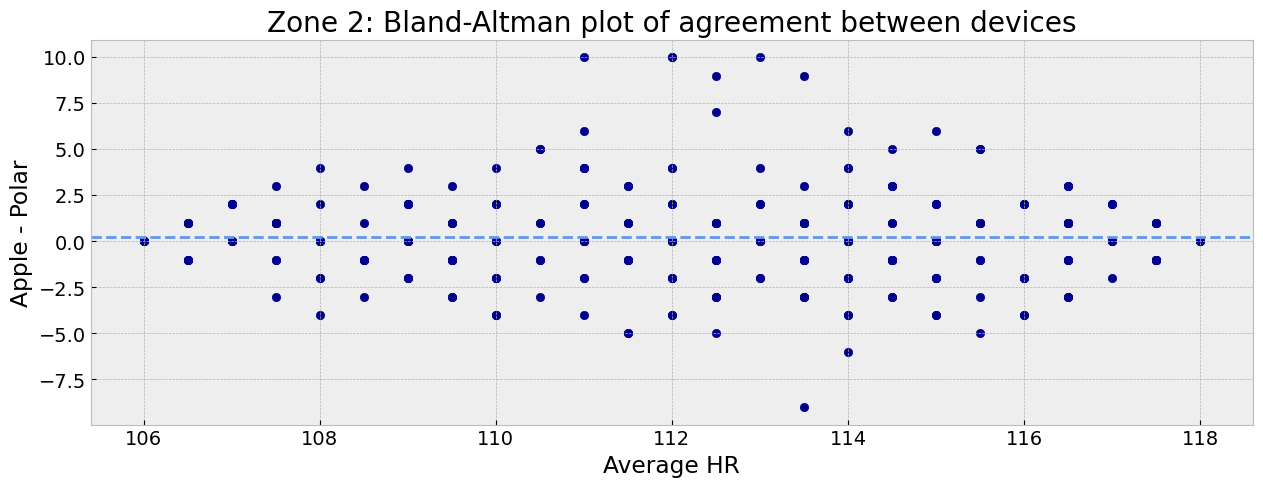

Zone 2
MAE: 1.734 bpm
Pearson Correlation: 0.7383
ICC: 0.9992


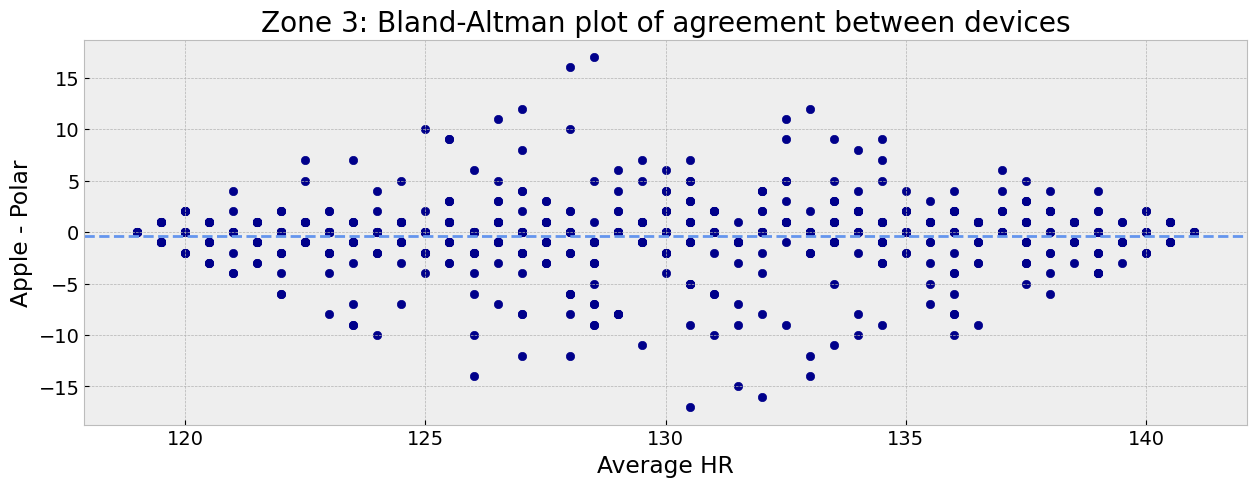

Zone 3
MAE: 2.082 bpm
Pearson Correlation: 0.8504
ICC: 0.9998


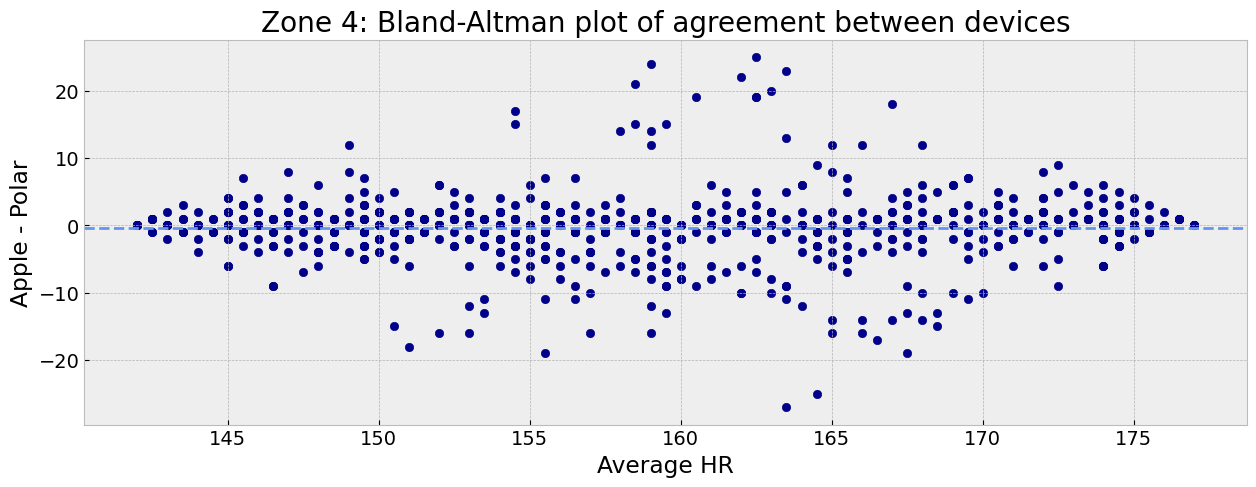

Zone 4
MAE: 2.781 bpm
Pearson Correlation: 0.8707
ICC: 0.9999


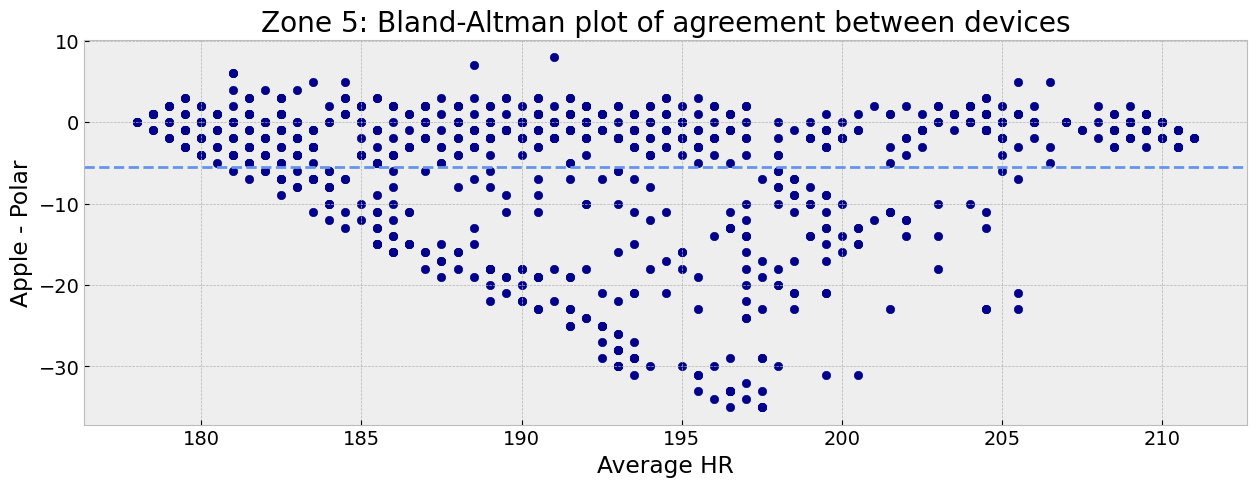

Zone 5
MAE: 6.223 bpm
Pearson Correlation: 0.5912
ICC: 0.9994


In [36]:
''' 
Step 5: Plot & Evaluate (by HR zone)
'''

for zone in zone_names:
    temp_watch = watch_zones[watch_zones["Zones"]==zone]
    temp_polar = polar_zones[polar_zones["Zones"]==zone]

    polar_sync = temp_polar[temp_polar["Datetime"].isin(temp_watch["Datetime"])].reset_index()["HR"].astype(int)
    watch_sync = temp_watch[temp_watch["Datetime"].isin(temp_polar["Datetime"])].reset_index()["HR"].astype(int)
    
    # Bland-Altman Plot
    mean_hr = np.mean([watch_sync, polar_sync], axis=0)
    diff_hr = watch_sync - polar_sync

    plt.scatter(mean_hr, diff_hr, color="darkblue")
    plt.axhline(np.mean(diff_hr), linestyle='--', color="cornflowerblue") 
    plt.title(f"{zone}: Bland-Altman plot of agreement between devices")
    plt.ylabel('Apple - Polar')
    plt.xlabel('Average HR')
    plt.savefig(f'/Users/ellismims/Documents/F23/290T/project/fig/{zone}_bland.png', transparent=True);
    plt.show()

    print(f"{zone}")
    # Mean Absolute Error
    mae_val=mae(watch_sync, polar_sync)
    print(f'MAE: {mae_val:.4} bpm')

    # Pearson Correlation 
    pearsons=scipy.stats.pearsonr(watch_sync, polar_sync)
    print(f'Pearson Correlation: {pearsons[0]:.4}')

    # ICC 
    icc_val=icc(watch_sync, polar_sync)
    print(f'ICC: {icc_val:.4}')

    mae_dict[zone]=mae_val
    pearsons_dict[zone]=pearsons
    icc_dict[zone]=icc_val

In [ ]:
print(mae_dict)
print(pearsons_dict)
print(icc_dict)

{'10-18': 3.8662576687116563, '11-17': 3.8662576687116563, '11-20': 4.5080831408775985, '11-22': 5.743951612903226, 'total': 4.554460864805693, 'Zone 1': 1.643835616438356, 'Zone 2': 1.7337461300309598, 'Zone 3': 2.0816326530612246, 'Zone 4': 2.7805429864253393, 'Zone 5': 6.222870478413069}
{'10-18': PearsonRResult(statistic=0.9703336337288887, pvalue=0.0), '11-17': PearsonRResult(statistic=0.9703336337288887, pvalue=0.0), '11-20': PearsonRResult(statistic=0.9666220819527162, pvalue=0.0), '11-22': PearsonRResult(statistic=0.9499064089338923, pvalue=0.0), 'total': PearsonRResult(statistic=0.9688855593205338, pvalue=0.0), 'Zone 1': PearsonRResult(statistic=0.9069005381228831, pvalue=2.5545977081016044e-138), 'Zone 2': PearsonRResult(statistic=0.7382578299454888, pvalue=7.692770595745158e-57), 'Zone 3': PearsonRResult(statistic=0.8503688558173169, pvalue=1.3650204333780614e-206), 'Zone 4': PearsonRResult(statistic=0.8707263913356169, pvalue=4.1824283751865163e-274), 'Zone 5': PearsonRResu